``lux.ai - Curso de Fotografia Computacional - Aprendizado de Máquina e Profundo``

---
# **Restauração de Imagens com UNet**
---

```OBS: Quando pedido, realize a operação na célula correspondente atribuindo o resultado na variável indicada. Não altere os nomes das variáveis utilizadas. Você pode utilizar células adicionais para realizar testes, utilizando variáveis auxiliares para visualizar resultados intermediários.```

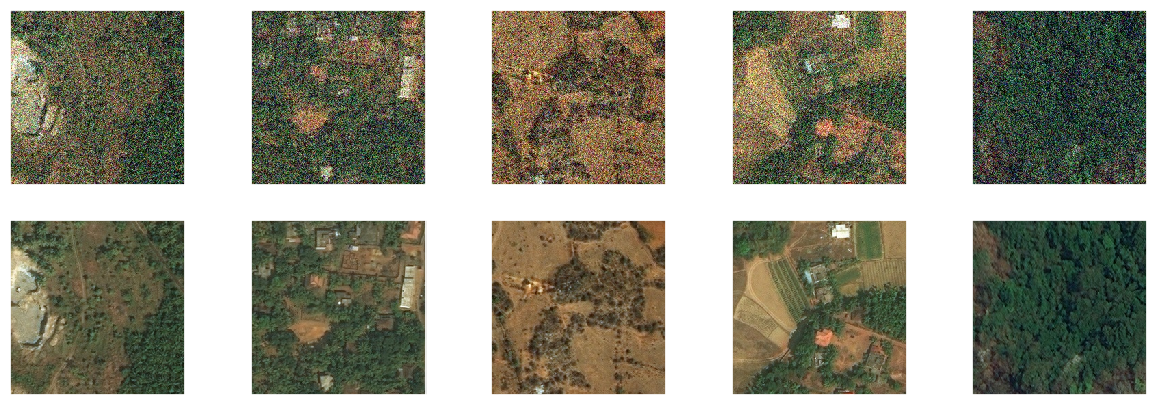

Nesta atividade, vamos gerar um modelo de **Deep Learning** que identifica e remove o ruído de imagens aéreas, como nos exemplos acima. As imagens foram obtidas a partir do conjunto de dados [**Forest Aerial Images for Segmentation**](https://www.kaggle.com/datasets/quadeer15sh/augmented-forest-segmentation?resource=download).

---
## **01 - Imports**
---

In [ ]:
# Modelagem e dados
import torch
from torchvision import transforms, datasets, models
from torch import nn, optim
from torch.utils import data

# Avaliação de modelos
from sklearn.model_selection import train_test_split

# Plotting e visualização
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Operações com imagens
import cv2
from PIL import Image
import albumentations as A

# Outros
import zipfile
import os
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm

In [ ]:
# Fazer o download do dataset
!gdown 19nkkxpK8LN7fk9VPCdR1heatXhQKNWtO
!unzip kaggle_forest_segmentation.zip -d .

Streaming output truncated to the last 5000 lines.
  inflating: ./kaggle_forest_segmentation/Forest Segmented/Forest Segmented/masks/174980_mask_70.jpg  
  inflating: ./kaggle_forest_segmentation/Forest Segmented/Forest Segmented/masks/174980_mask_88.jpg  
  inflating: ./kaggle_forest_segmentation/Forest Segmented/Forest Segmented/masks/176225_mask_10.jpg  
  inflating: ./kaggle_forest_segmentation/Forest Segmented/Forest Segmented/masks/176225_mask_53.jpg  
  inflating: ./kaggle_forest_segmentation/Forest Segmented/Forest Segmented/masks/176225_mask_55.jpg  
  inflating: ./kaggle_forest_segmentation/Forest Segmented/Forest Segmented/masks/176225_mask_63.jpg  
  inflating: ./kaggle_forest_segmentation/Forest Segmented/Forest Segmented/masks/176225_mask_77.jpg  
  inflating: ./kaggle_forest_segmentation/Forest Segmented/Forest Segmented/masks/182422_mask_05.jpg  
  inflating: ./kaggle_forest_segmentation/Forest Segmented/Forest Segmented/masks/182422_mask_07.jpg  
  inflating: ./kaggle_

In [ ]:
class AverageMeter:
    """Computes and stores the average and current value"""
    # Fonte: https://kaiyangzhou.github.io/deep-person-reid/_modules/torchreid/utils/avgmeter.html#AverageMeter
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

---
## **02 - Datasets e DataLoaders**
---

### **Q1.1 Adição do Ruído Gaussiano**


In [ ]:
def add_noise(image, sigma) -> np.array:
    # Média, desvio padrão e tamanho
    loc = 0.0
    scale = sigma / 255
    size = image.shape

    # Ruído gaussiano
    noise = np.random.normal(loc, scale, size)
    image = image + noise
    image = np.clip(image, 0, 1)

    return image

In [ ]:
metadata_file = "./kaggle_forest_segmentation/Forest Segmented/Forest Segmented/meta_data.csv"
metadata = pd.read_csv(metadata_file)
metadata.head()

,image,mask
0,10452_sat_08.jpg,10452_mask_08.jpg
1,10452_sat_18.jpg,10452_mask_18.jpg
2,111335_sat_00.jpg,111335_mask_00.jpg
3,111335_sat_01.jpg,111335_mask_01.jpg
4,111335_sat_02.jpg,111335_mask_02.jpg


In [ ]:
DIRECTORY = "./kaggle_forest_segmentation/Forest Segmented/Forest Segmented/"
SIGMA     = 50

if not os.path.exists(os.path.join(DIRECTORY, "noisy")):
    os.mkdir(os.path.join(DIRECTORY, "noisy"))

noisy_imgs = []

for i in tqdm(range(len(metadata))):
    path = os.path.join(DIRECTORY, "images", metadata.iloc[i]["image"])
    image = cv2.imread(path)
    image = image.astype("float32") / 255

    noisy = add_noise(image, SIGMA)
    noisy = (noisy * 255).astype('uint8')
    noisy_path = os.path.join(DIRECTORY, "noisy", metadata.iloc[i]["image"].replace("sat", "noisy"))

    if cv2.imwrite(noisy_path, noisy):
        noisy_imgs.append(metadata.iloc[i]["image"].replace("sat", "noisy"))
    else:
        noisy_imgs.append(np.nan)

metadata["noisy"] = noisy_imgs

# ------------------------------
# |     Estrutura da pasta     |
# -----------------------------|
# | kaggle_forest_segmentation |
# |   Forest Segmented/        |
# |     Forest Segmented/      |
# |       images/              |
# |       masks/               |
# |       noisy/               |
# |       meta_data.csv        |
# ------------------------------

100%|██████████| 5108/5108 [01:08<00:00, 74.62it/s]


In [ ]:
metadata.head()

,image,mask,noisy
0,10452_sat_08.jpg,10452_mask_08.jpg,10452_noisy_08.jpg
1,10452_sat_18.jpg,10452_mask_18.jpg,10452_noisy_18.jpg
2,111335_sat_00.jpg,111335_mask_00.jpg,111335_noisy_00.jpg
3,111335_sat_01.jpg,111335_mask_01.jpg,111335_noisy_01.jpg
4,111335_sat_02.jpg,111335_mask_02.jpg,111335_noisy_02.jpg


In [ ]:
train_valid_paths, test_paths = train_test_split(metadata, test_size=0.2)
train_paths, valid_paths = train_test_split(train_valid_paths, test_size=0.15)

In [ ]:
# Os exemplos estarão dividos e serão acessados através do DataFrame carregado
train_paths.shape[0], valid_paths.shape[0], test_paths.shape[0]

(3473, 613, 1022)

### **Q1.2 Criação da Classe dos Datasets**

In [ ]:
class ForestImages(data.Dataset):
    def __init__(self, paths):
        # Paths das imagens originais e das imagens com ruído
        self.paths = paths

        # Transformações
        self.transforms = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        # Paths da imagem original e da imagem com ruído
        paths = self.paths.iloc[index]
        image_path = os.path.join(DIRECTORY, "images", paths["image"])
        noisy_path = os.path.join(DIRECTORY, "noisy", paths["noisy"])

        # Leitura das imagens
        image = cv2.imread(image_path)
        noisy = cv2.imread(noisy_path)

        # Conversão para RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        noisy = cv2.cvtColor(noisy, cv2.COLOR_BGR2RGB)

        # Tranformação para torch.Tensor, ajuste das dimensões e normalização
        image = self.transforms(image)
        noisy = self.transforms(noisy)

        return noisy, image

### **Q1.3 Criação dos Datasets e DataLoaders de Treino, Validação e Teste**

In [ ]:
train_ds = ForestImages(train_paths)
valid_ds = ForestImages(valid_paths)
test_ds  = ForestImages(test_paths)

train_dl = data.DataLoader(train_ds, batch_size=32, shuffle=True,
                           num_workers=2, pin_memory=True)

valid_dl = data.DataLoader(valid_ds, batch_size=64, shuffle=True,
                           num_workers=2, pin_memory=True)

test_dl  = data.DataLoader(test_ds, batch_size=64, shuffle=True,
                           num_workers=2, pin_memory=True)

instances, targets = next(iter(train_dl))

print(instances.shape, targets.shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])


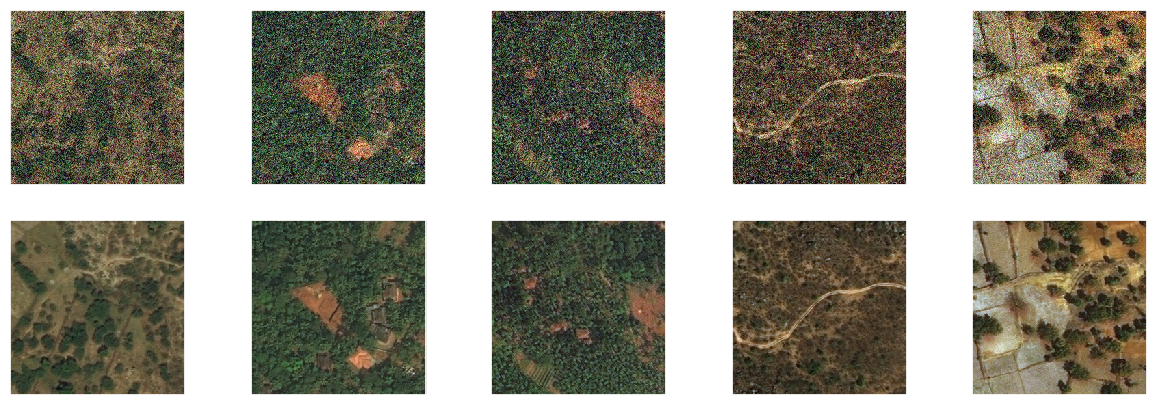

In [ ]:
w = 5
fig, ax = plt.subplots(2, w, figsize=(15, 5))

for j in range(w):
    noisy = (255 * instances[j]).permute(1, 2, 0).numpy().astype("uint8")
    image = (255 * targets[j]).permute(1, 2, 0).numpy().astype("uint8")

    ax[0][j].imshow(noisy, cmap="gray", interpolation="None")
    ax[0][j].set_xticks([])
    ax[0][j].set_yticks([])

    ax[1][j].imshow(image, interpolation="None")
    ax[1][j].set_xticks([])
    ax[1][j].set_yticks([])

---
## **03 - Definição do Modelo**
---

### **Q2.1 Construção do CCBlock**

In [ ]:
class CCBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels,
                               out_channels,
                               3, 1, 1)

        self.conv2 = nn.Conv2d(out_channels,
                               out_channels,
                               3, 1, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x

### **Q2.2 Construção do UPBlock**

In [ ]:
class UPBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_transpose = nn.ConvTranspose2d(in_channels,
                                                 int(in_channels / 2),
                                                 2, 2)

        self.ccblock = CCBlock(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.conv_transpose(x)
        x = torch.cat([x, skip], 1)
        x = self.ccblock(x)
        return x

### **Q2.3 Construção do Modelo UNet**

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.ccblock1 = CCBlock(in_channels, 64)
        self.ccblock2 = CCBlock(64, 128)
        self.ccblock3 = CCBlock(128, 256)
        self.ccblock4 = CCBlock(256, 512)
        self.ccblock5 = CCBlock(512, 1024)

        self.upblock1 = UPBlock(1024, 512)
        self.upblock2 = UPBlock(512, 256)
        self.upblock3 = UPBlock(256, 128)
        self.upblock4 = UPBlock(128, 64)
        self.conv2d = nn.Conv2d(64, out_channels, 3, 1, 1)

    def forward(self, x):
        cc1 = self.ccblock1(x)
        mp1 = self.pool(cc1)
        cc2 = self.ccblock2(mp1)
        mp2 = self.pool(cc2)
        cc3 = self.ccblock3(mp2)
        mp3 = self.pool(cc3)
        cc4 = self.ccblock4(mp3)
        mp4 = self.pool(cc4)
        cc5 = self.ccblock5(mp4)

        up1 = self.upblock1(cc5, cc4)
        up2 = self.upblock2(up1, cc3)
        up3 = self.upblock3(up2, cc2)
        up4 = self.upblock4(up3, cc1)

        conv = self.conv2d(up4)
        x = x + conv

        return x

### **Q2.4 Criação da Instância do Modelo**

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
model = UNet().to(device)

### **Q2.5 Summary do Modelo**

In [ ]:
summary(UNet().to(device), (3, 256, 256), 1, device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 256, 256]           1,792
              ReLU-2          [1, 64, 256, 256]               0
            Conv2d-3          [1, 64, 256, 256]          36,928
              ReLU-4          [1, 64, 256, 256]               0
           CCBlock-5          [1, 64, 256, 256]               0
         MaxPool2d-6          [1, 64, 128, 128]               0
            Conv2d-7         [1, 128, 128, 128]          73,856
              ReLU-8         [1, 128, 128, 128]               0
            Conv2d-9         [1, 128, 128, 128]         147,584
             ReLU-10         [1, 128, 128, 128]               0
          CCBlock-11         [1, 128, 128, 128]               0
        MaxPool2d-12           [1, 128, 64, 64]               0
           Conv2d-13           [1, 256, 64, 64]         295,168
             ReLU-14           [1, 256,

---
## **04 - Treinamento**
---

### **Q3.1 Implementação do Passo de Treinamento**

In [ ]:
def train_step(model, loader, loss_fn, optimizer, device) -> float:
    model.train()

    train_loss = AverageMeter()
    for instance, target in loader:
        instance = instance.to(device.type)
        target = target.to(device.type)

        optimizer.zero_grad()
        output = model(instance)

        loss = loss_fn(output, target)
        train_loss.update(loss.item(), len(instance))

        loss.backward()
        optimizer.step()

    return train_loss.avg


### **Q3.2 Implementação do Passo de Validação**

In [ ]:
def validation_step(model, loader, loss_fn, device) -> float:
    model.eval()

    valid_loss = AverageMeter()
    with torch.no_grad():
        for instance, target in loader:
            instance = instance.to(device.type)
            target = target.to(device.type)

            output = model(instance)
            loss = loss_fn(output, target)
            valid_loss.update(loss.item(), len(instance))

    return valid_loss.avg

### **Q3.3 Função de Execução de Treino**

In [ ]:
# Optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Função de Loss
loss_fn = nn.L1Loss()

# Número de épocas
EPOCHS = 40

In [ ]:
train_losses = list()
valid_losses = list()

In [ ]:
def train_model():
    for epoch in range(EPOCHS):
        train_loss = train_step(model, train_dl, loss_fn, optimizer, device)
        valid_loss = validation_step(model, valid_dl, loss_fn, device)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f"Epoch [{epoch + 1}/{EPOCHS}]")
        print("-" * 35)
        print(f"train_loss: {round(train_loss, 6):<7}")
        print(f"valid_loss: {round(valid_loss, 6):<7}\n")

In [ ]:
train_model()

Epoch [1/40]
-----------------------------------
train_loss: 0.051118
valid_loss: 0.035589

Epoch [2/40]
-----------------------------------
train_loss: 0.034905
valid_loss: 0.033665

Epoch [3/40]
-----------------------------------
train_loss: 0.033737
valid_loss: 0.032818

Epoch [4/40]
-----------------------------------
train_loss: 0.032993
valid_loss: 0.031838

Epoch [5/40]
-----------------------------------
train_loss: 0.031801
valid_loss: 0.031318

Epoch [6/40]
-----------------------------------
train_loss: 0.031537
valid_loss: 0.031116

Epoch [7/40]
-----------------------------------
train_loss: 0.031147
valid_loss: 0.030951

Epoch [8/40]
-----------------------------------
train_loss: 0.030952
valid_loss: 0.030721

Epoch [9/40]
-----------------------------------
train_loss: 0.030792
valid_loss: 0.030478

Epoch [10/40]
-----------------------------------
train_loss: 0.03061
valid_loss: 0.030278

Epoch [11/40]
-----------------------------------
train_loss: 0.030542
valid_los

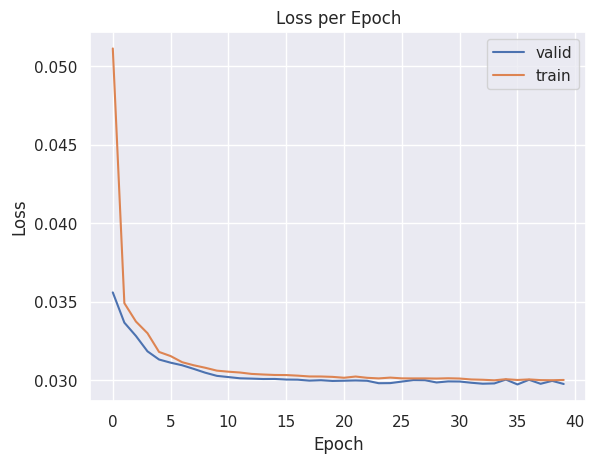

In [ ]:
def plot_loss(loss_train, loss_valid):
    plt.plot(loss_valid, label='valid')
    plt.plot(loss_train, label='train')

    plt.title('Loss per Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.legend()
    plt.show()

plot_loss(train_losses, valid_losses)

### **Q3.5 Armazenamento do Modelo**

In [ ]:
torch.save(model.state_dict(), "./UNet.pt")


### **Q4 Teste do Modelo**

In [ ]:
test_instances, test_targets = next(iter(test_dl))
test_outputs = None

test_instances = test_instances.to(device.type)
test_targets = test_targets.to(device.type)

model.eval()
with torch.no_grad():
    test_outputs = model(test_instances)

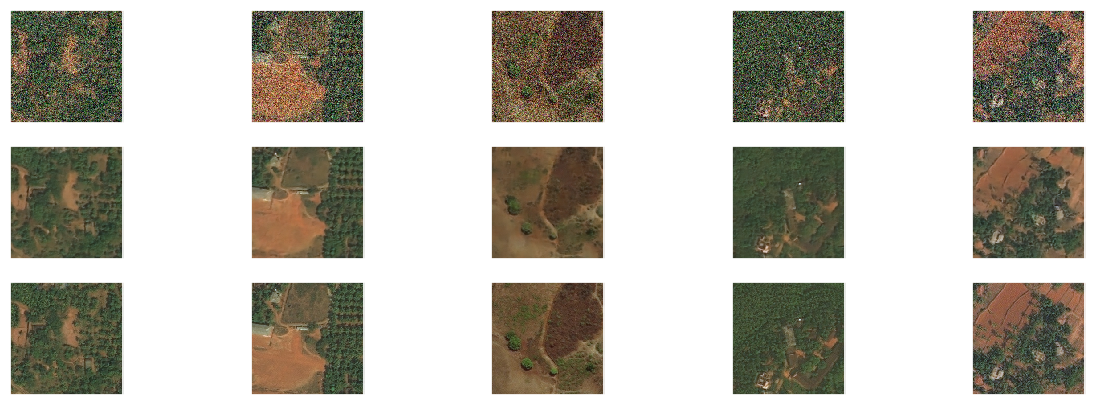

In [ ]:
w = 5
fig, ax = plt.subplots(3, w, figsize=(15, 5))

for j in range(w):
    noisy = (255 * test_instances[j].cpu()).permute(1, 2, 0).numpy().astype("uint8")
    output = (255 * test_outputs[j].cpu()).permute(1, 2, 0).numpy().astype("uint8")
    image = (255 * test_targets[j].cpu()).permute(1, 2, 0).numpy().astype("uint8")

    ax[0][j].imshow(noisy, cmap="gray", interpolation="None")
    ax[0][j].set_xticks([])
    ax[0][j].set_yticks([])

    ax[1][j].imshow(output, cmap="gray", interpolation="None")
    ax[1][j].set_xticks([])
    ax[1][j].set_yticks([])

    ax[2][j].imshow(image, interpolation="None")
    ax[2][j].set_xticks([])
    ax[2][j].set_yticks([])